In [1]:
# Hyperparameters
N_EPOCH=200
BATCH_SIZE=64
LR=0.0002
B1=0.5
B2=0.999
N_CPU=8
LATENT_DIM=100
IMG_SIZE=32
CHANNELS=1
N_CRITIC=5
CLIP_VALUE=0.01
SAMPLE_INTERVAL=400
DATA_DIR = "/home/giusy/datasets"

In [2]:
import os
import numpy as np
import math
import sys
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import make_grid
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch
from tqdm import tqdm

from matplotlib import pyplot as plt
import sys

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(os.path.join(DATA_DIR,"images_wgan_gp_original"), exist_ok=True)

class Parser:
    n_epochs= N_EPOCH
    batch_size= BATCH_SIZE
    lr= LR
    b1= B1
    b2= B2
    n_cpu= N_CPU
    latent_dim= LATENT_DIM
    img_size= IMG_SIZE
    channels= CHANNELS
    n_critic= N_CRITIC
    clip_value= CLIP_VALUE
    sample_interval= SAMPLE_INTERVAL
    data_dir = DATA_DIR

opt = Parser()

%matplotlib inline

In [3]:
img_shape = (opt.channels, opt.img_size, opt.img_size)

In [4]:
cuda = True if torch.cuda.is_available() else False

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


In [6]:
# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs(opt.data_dir, exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(root=opt.data_dir,train=True,download=False,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    num_workers=opt.n_cpu,
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [7]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: DL=-8.0255, GL=-1.9237


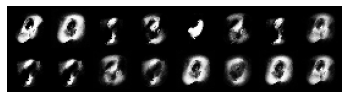

  0%|          | 1/200 [00:13<45:00, 13.57s/it]

Epoch 2: DL=-5.7586, GL=-0.6581


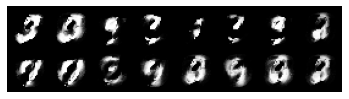

  1%|          | 2/200 [00:27<44:43, 13.55s/it]

Epoch 3: DL=-7.4397, GL=0.9655


  2%|▏         | 3/200 [00:40<43:42, 13.31s/it]

Epoch 4: DL=-6.7348, GL=0.8941


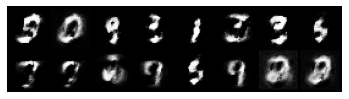

  2%|▏         | 4/200 [00:52<42:26, 12.99s/it]

Epoch 5: DL=-6.4476, GL=0.5344


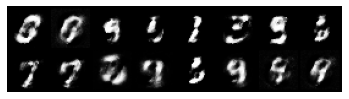

  2%|▎         | 5/200 [01:05<42:21, 13.04s/it]

Epoch 6: DL=-5.8772, GL=0.1984


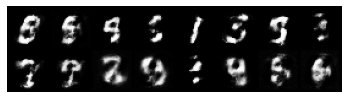

  3%|▎         | 6/200 [01:18<42:04, 13.01s/it]

Epoch 7: DL=-5.2577, GL=0.1340


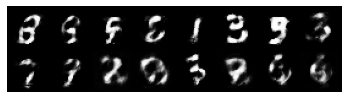

  4%|▎         | 7/200 [01:31<42:06, 13.09s/it]

Epoch 8: DL=-4.8234, GL=0.1365


  4%|▍         | 8/200 [01:44<41:46, 13.06s/it]

Epoch 9: DL=-4.5187, GL=0.0586


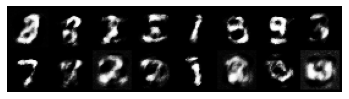

  4%|▍         | 9/200 [01:58<41:33, 13.06s/it]

Epoch 10: DL=-4.1767, GL=-0.0426


  5%|▌         | 10/200 [02:11<41:38, 13.15s/it]

Epoch 11: DL=-3.9536, GL=-0.0730


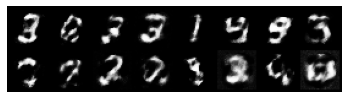

  6%|▌         | 11/200 [02:24<41:28, 13.16s/it]

Epoch 12: DL=-3.6948, GL=-0.2729


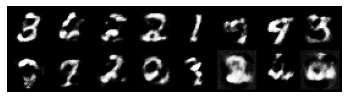

  6%|▌         | 12/200 [02:37<41:16, 13.17s/it]

Epoch 13: DL=-3.4911, GL=-0.3057


  6%|▋         | 13/200 [02:59<48:46, 15.65s/it]

Epoch 14: DL=-3.2542, GL=-0.4069


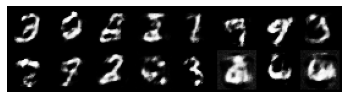

  7%|▋         | 14/200 [03:20<53:45, 17.34s/it]

Epoch 15: DL=-3.0499, GL=-0.4025


  8%|▊         | 15/200 [03:41<57:04, 18.51s/it]

Epoch 16: DL=-2.9437, GL=-0.4007


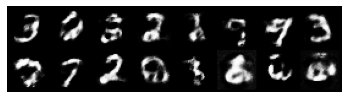

  8%|▊         | 16/200 [04:02<59:04, 19.26s/it]

Epoch 17: DL=-2.8050, GL=-0.3978


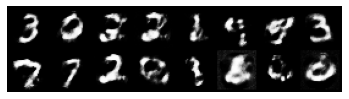

  8%|▊         | 17/200 [04:24<1:00:44, 19.91s/it]

Epoch 18: DL=-2.6669, GL=-0.4330


  9%|▉         | 18/200 [04:45<1:01:33, 20.29s/it]

Epoch 19: DL=-2.6021, GL=-0.4740


 10%|▉         | 19/200 [05:06<1:01:49, 20.49s/it]

Epoch 20: DL=-2.5578, GL=-0.4268


 10%|█         | 20/200 [05:27<1:02:04, 20.69s/it]

Epoch 21: DL=-2.4968, GL=-0.3915


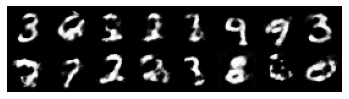

 10%|█         | 21/200 [05:48<1:02:19, 20.89s/it]

Epoch 22: DL=-2.4303, GL=-0.4009


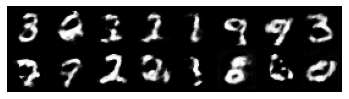

 11%|█         | 22/200 [06:15<1:07:27, 22.74s/it]

Epoch 23: DL=-2.3383, GL=-0.4283


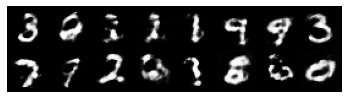

 12%|█▏        | 23/200 [06:45<1:13:25, 24.89s/it]

Epoch 24: DL=-2.3108, GL=-0.4599


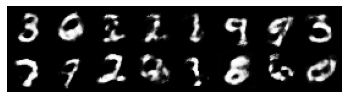

 12%|█▏        | 24/200 [07:15<1:17:35, 26.45s/it]

Epoch 25: DL=-2.2416, GL=-0.4626


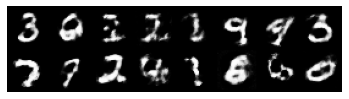

 12%|█▎        | 25/200 [07:45<1:20:19, 27.54s/it]

Epoch 26: DL=-2.1861, GL=-0.4779


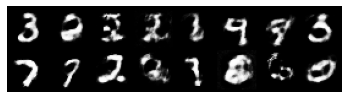

 13%|█▎        | 26/200 [08:15<1:21:56, 28.25s/it]

Epoch 27: DL=-2.0888, GL=-0.4981


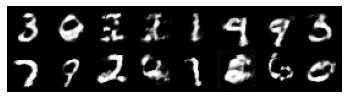

 14%|█▎        | 27/200 [08:45<1:23:03, 28.81s/it]

Epoch 28: DL=-2.0584, GL=-0.5180


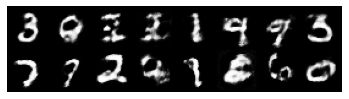

 14%|█▍        | 28/200 [09:15<1:23:37, 29.17s/it]

Epoch 29: DL=-2.0042, GL=-0.5443


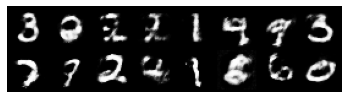

 14%|█▍        | 29/200 [09:45<1:23:55, 29.45s/it]

Epoch 30: DL=-1.9724, GL=-0.5386


 15%|█▌        | 30/200 [10:15<1:23:47, 29.57s/it]

Epoch 31: DL=-1.9286, GL=-0.5307


 16%|█▌        | 31/200 [10:45<1:23:40, 29.71s/it]

Epoch 32: DL=-1.8827, GL=-0.5025


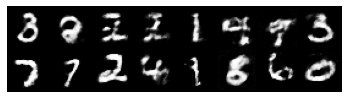

 16%|█▌        | 32/200 [11:15<1:23:29, 29.82s/it]

Epoch 33: DL=-1.8298, GL=-0.5292


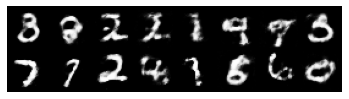

 16%|█▋        | 33/200 [11:45<1:22:55, 29.79s/it]

Epoch 34: DL=-1.7899, GL=-0.5293


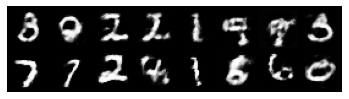

 17%|█▋        | 34/200 [12:15<1:22:45, 29.91s/it]

Epoch 35: DL=-1.7528, GL=-0.5369


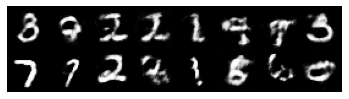

 18%|█▊        | 35/200 [12:45<1:22:21, 29.95s/it]

Epoch 36: DL=-1.7269, GL=-0.5562


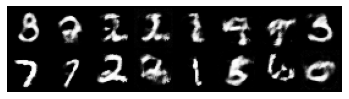

 18%|█▊        | 36/200 [13:16<1:22:02, 30.01s/it]

Epoch 37: DL=-1.6840, GL=-0.5475


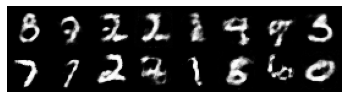

 18%|█▊        | 37/200 [13:45<1:21:21, 29.95s/it]

Epoch 38: DL=-1.6722, GL=-0.5301


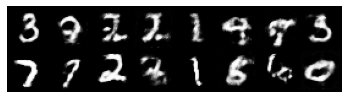

 19%|█▉        | 38/200 [14:16<1:21:10, 30.06s/it]

Epoch 39: DL=-1.6449, GL=-0.5456


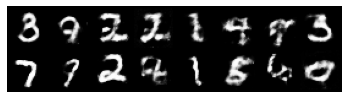

 20%|█▉        | 39/200 [14:46<1:20:50, 30.13s/it]

Epoch 40: DL=-1.5946, GL=-0.5430


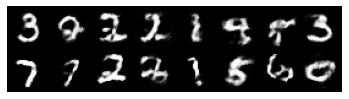

 20%|██        | 40/200 [15:16<1:19:59, 30.00s/it]

Epoch 41: DL=-1.5741, GL=-0.5150


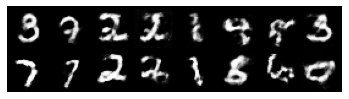

 20%|██        | 41/200 [15:46<1:19:37, 30.05s/it]

Epoch 42: DL=-1.5601, GL=-0.5000


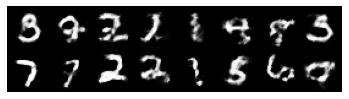

 21%|██        | 42/200 [16:16<1:19:08, 30.05s/it]

Epoch 43: DL=-1.5264, GL=-0.5188


 22%|██▏       | 43/200 [16:46<1:18:42, 30.08s/it]

Epoch 44: DL=-1.5011, GL=-0.5299


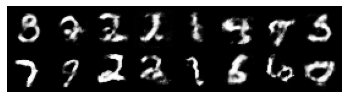

 22%|██▏       | 44/200 [17:16<1:18:00, 30.00s/it]

Epoch 45: DL=-1.4860, GL=-0.4719


 22%|██▎       | 45/200 [17:46<1:17:28, 29.99s/it]

Epoch 46: DL=-1.4692, GL=-0.4999


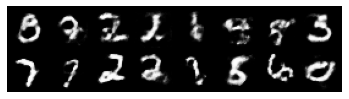

 23%|██▎       | 46/200 [18:16<1:17:02, 30.02s/it]

Epoch 47: DL=-1.4494, GL=-0.4989


 24%|██▎       | 47/200 [18:46<1:16:35, 30.03s/it]

Epoch 48: DL=-1.4271, GL=-0.4954


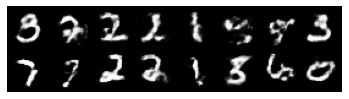

 24%|██▍       | 48/200 [19:16<1:16:02, 30.02s/it]

Epoch 49: DL=-1.4089, GL=-0.4350


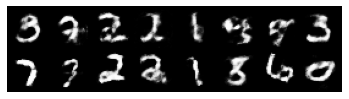

 24%|██▍       | 49/200 [19:46<1:15:37, 30.05s/it]

Epoch 50: DL=-1.3833, GL=-0.4599


 25%|██▌       | 50/200 [20:16<1:15:15, 30.10s/it]

Epoch 51: DL=-1.3741, GL=-0.4792


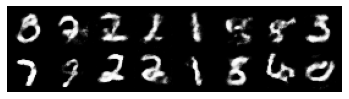

 26%|██▌       | 51/200 [20:46<1:14:35, 30.03s/it]

Epoch 52: DL=-1.3467, GL=-0.4712


 26%|██▌       | 52/200 [21:16<1:14:11, 30.08s/it]

Epoch 53: DL=-1.3458, GL=-0.4786


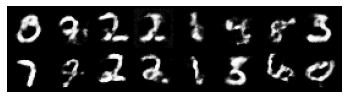

 26%|██▋       | 53/200 [21:46<1:13:44, 30.10s/it]

Epoch 54: DL=-1.3258, GL=-0.4549


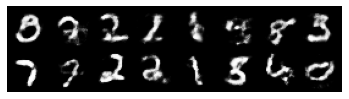

 27%|██▋       | 54/200 [22:16<1:13:04, 30.03s/it]

Epoch 55: DL=-1.3043, GL=-0.4746


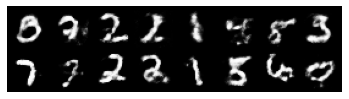

 28%|██▊       | 55/200 [22:47<1:12:45, 30.11s/it]

Epoch 56: DL=-1.2964, GL=-0.4715


 28%|██▊       | 56/200 [23:17<1:12:09, 30.06s/it]

Epoch 57: DL=-1.2917, GL=-0.4736


 28%|██▊       | 57/200 [23:47<1:11:48, 30.13s/it]

Epoch 58: DL=-1.2666, GL=-0.4536


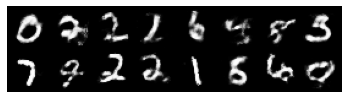

 29%|██▉       | 58/200 [24:17<1:11:06, 30.05s/it]

Epoch 59: DL=-1.2611, GL=-0.4297


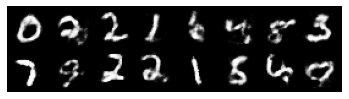

 30%|██▉       | 59/200 [24:47<1:10:47, 30.12s/it]

Epoch 60: DL=-1.2431, GL=-0.4783


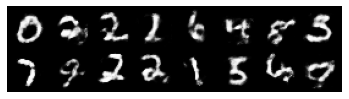

 30%|███       | 60/200 [25:17<1:10:13, 30.10s/it]

Epoch 61: DL=-1.2349, GL=-0.4739


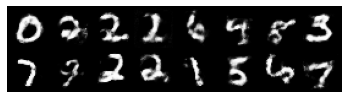

 30%|███       | 61/200 [25:47<1:09:35, 30.04s/it]

Epoch 62: DL=-1.2287, GL=-0.4951


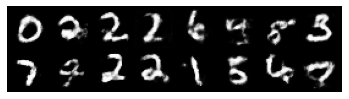

 31%|███       | 62/200 [26:17<1:09:08, 30.06s/it]

Epoch 63: DL=-1.2219, GL=-0.4406


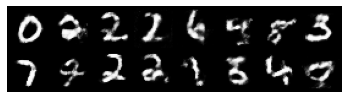

 32%|███▏      | 63/200 [26:47<1:08:43, 30.10s/it]

Epoch 64: DL=-1.2059, GL=-0.4482


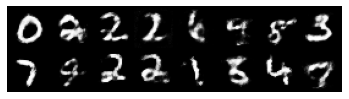

 32%|███▏      | 64/200 [27:17<1:08:09, 30.07s/it]

Epoch 65: DL=-1.2134, GL=-0.4326


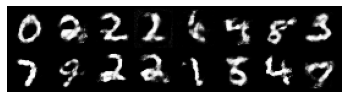

 32%|███▎      | 65/200 [27:47<1:07:37, 30.06s/it]

Epoch 66: DL=-1.2007, GL=-0.4324


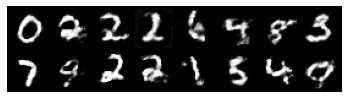

 33%|███▎      | 66/200 [28:17<1:07:11, 30.08s/it]

Epoch 67: DL=-1.1758, GL=-0.4477


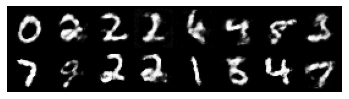

 34%|███▎      | 67/200 [28:47<1:06:36, 30.05s/it]

Epoch 68: DL=-1.1742, GL=-0.4392


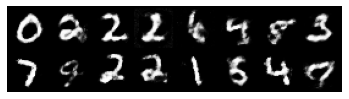

 34%|███▍      | 68/200 [29:18<1:06:12, 30.09s/it]

Epoch 69: DL=-1.1710, GL=-0.4068


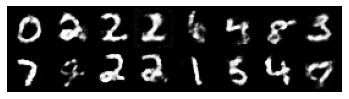

 34%|███▍      | 69/200 [29:48<1:05:37, 30.06s/it]

Epoch 70: DL=-1.1519, GL=-0.4183


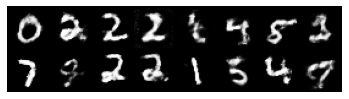

 35%|███▌      | 70/200 [30:18<1:05:11, 30.09s/it]

Epoch 71: DL=-1.1590, GL=-0.4113


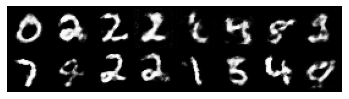

 36%|███▌      | 71/200 [30:48<1:04:42, 30.09s/it]

Epoch 72: DL=-1.1434, GL=-0.4496


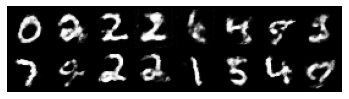

 36%|███▌      | 72/200 [31:18<1:04:02, 30.02s/it]

Epoch 73: DL=-1.1389, GL=-0.4618


 36%|███▋      | 73/200 [31:48<1:03:32, 30.02s/it]

Epoch 74: DL=-1.1281, GL=-0.4526


 37%|███▋      | 74/200 [32:18<1:03:08, 30.07s/it]

Epoch 75: DL=-1.1099, GL=-0.4386


 38%|███▊      | 75/200 [32:48<1:02:29, 30.00s/it]

Epoch 76: DL=-1.1109, GL=-0.3953


 38%|███▊      | 76/200 [33:18<1:02:04, 30.04s/it]

Epoch 77: DL=-1.0991, GL=-0.4107


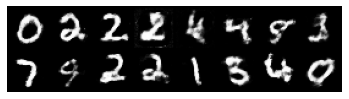

 38%|███▊      | 77/200 [33:48<1:01:37, 30.06s/it]

Epoch 78: DL=-1.0889, GL=-0.4331


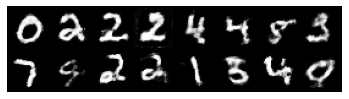

 39%|███▉      | 78/200 [34:18<1:01:09, 30.07s/it]

Epoch 79: DL=-1.0860, GL=-0.4391


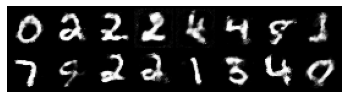

 40%|███▉      | 79/200 [34:48<1:00:30, 30.01s/it]

Epoch 80: DL=-1.0766, GL=-0.4235


 40%|████      | 80/200 [35:18<1:00:09, 30.08s/it]

Epoch 81: DL=-1.0684, GL=-0.4148


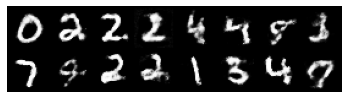

 40%|████      | 81/200 [35:48<59:40, 30.09s/it]  

Epoch 82: DL=-1.0489, GL=-0.3963


 41%|████      | 82/200 [36:18<59:05, 30.05s/it]

Epoch 83: DL=-1.0537, GL=-0.4142


 42%|████▏     | 83/200 [36:48<58:33, 30.03s/it]

Epoch 84: DL=-1.0603, GL=-0.3960


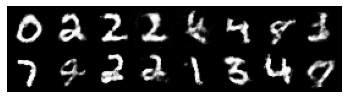

 42%|████▏     | 84/200 [37:18<58:05, 30.04s/it]

Epoch 85: DL=-1.0355, GL=-0.4074


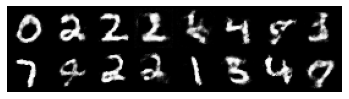

 42%|████▎     | 85/200 [37:48<57:37, 30.07s/it]

Epoch 86: DL=-1.0262, GL=-0.4188


 43%|████▎     | 86/200 [38:19<57:12, 30.11s/it]

Epoch 87: DL=-1.0319, GL=-0.3792


 44%|████▎     | 87/200 [38:49<56:41, 30.10s/it]

Epoch 88: DL=-1.0404, GL=-0.3910


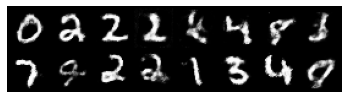

 44%|████▍     | 88/200 [39:19<56:08, 30.08s/it]

Epoch 89: DL=-1.0165, GL=-0.3963


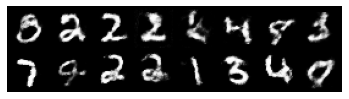

 44%|████▍     | 89/200 [39:48<55:26, 29.97s/it]

Epoch 90: DL=-1.0078, GL=-0.3990


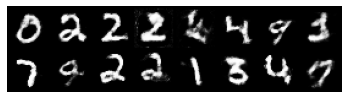

 45%|████▌     | 90/200 [40:19<55:00, 30.01s/it]

Epoch 91: DL=-1.0036, GL=-0.4002


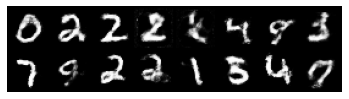

 46%|████▌     | 91/200 [40:49<54:38, 30.07s/it]

Epoch 92: DL=-1.0078, GL=-0.3982


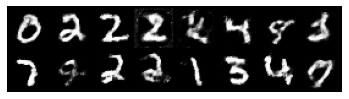

 46%|████▌     | 92/200 [41:19<53:58, 29.99s/it]

Epoch 93: DL=-0.9929, GL=-0.4570


 46%|████▋     | 93/200 [41:49<53:31, 30.01s/it]

Epoch 94: DL=-0.9992, GL=-0.4255


 47%|████▋     | 94/200 [42:19<53:05, 30.05s/it]

Epoch 95: DL=-0.9933, GL=-0.4055


 48%|████▊     | 95/200 [42:49<52:39, 30.09s/it]

Epoch 96: DL=-0.9655, GL=-0.4183


 48%|████▊     | 96/200 [43:19<52:04, 30.04s/it]

Epoch 97: DL=-0.9777, GL=-0.4018


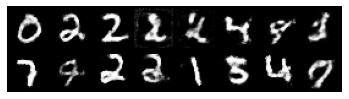

 48%|████▊     | 97/200 [43:49<51:42, 30.12s/it]

Epoch 98: DL=-0.9574, GL=-0.4489


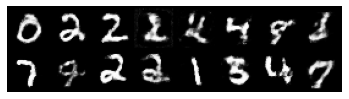

 49%|████▉     | 98/200 [44:19<51:10, 30.10s/it]

Epoch 99: DL=-0.9685, GL=-0.4123


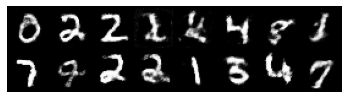

 50%|████▉     | 99/200 [44:49<50:29, 29.99s/it]

Epoch 100: DL=-0.9472, GL=-0.4505


 50%|█████     | 100/200 [45:19<49:59, 30.00s/it]

Epoch 101: DL=-0.9503, GL=-0.4217


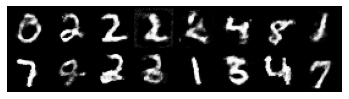

 50%|█████     | 101/200 [45:49<49:37, 30.07s/it]

Epoch 102: DL=-0.9475, GL=-0.4371


 51%|█████     | 102/200 [46:19<49:06, 30.06s/it]

Epoch 103: DL=-0.9377, GL=-0.4461


 52%|█████▏    | 103/200 [46:49<48:30, 30.00s/it]

Epoch 104: DL=-0.9210, GL=-0.4343


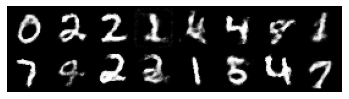

 52%|█████▏    | 104/200 [47:19<48:07, 30.08s/it]

Epoch 105: DL=-0.9297, GL=-0.4518


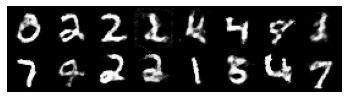

 52%|█████▎    | 105/200 [47:49<47:35, 30.06s/it]

Epoch 106: DL=-0.9166, GL=-0.4218


 53%|█████▎    | 106/200 [48:20<47:07, 30.08s/it]

Epoch 107: DL=-0.9284, GL=-0.4305


 54%|█████▎    | 107/200 [48:50<46:36, 30.07s/it]

Epoch 108: DL=-0.9111, GL=-0.4464


 54%|█████▍    | 108/200 [49:20<46:06, 30.07s/it]

Epoch 109: DL=-0.9123, GL=-0.4197


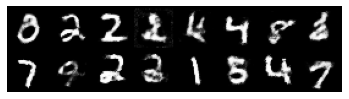

 55%|█████▍    | 109/200 [49:50<45:39, 30.11s/it]

Epoch 110: DL=-0.9078, GL=-0.4127


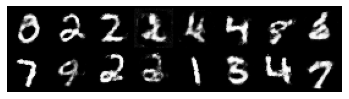

 55%|█████▌    | 110/200 [50:20<45:04, 30.05s/it]

Epoch 111: DL=-0.8996, GL=-0.4599


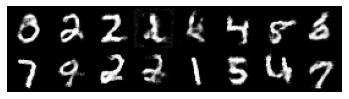

 56%|█████▌    | 111/200 [50:50<44:36, 30.07s/it]

Epoch 112: DL=-0.9021, GL=-0.4569


 56%|█████▌    | 112/200 [51:20<44:13, 30.15s/it]

Epoch 113: DL=-0.9015, GL=-0.4397


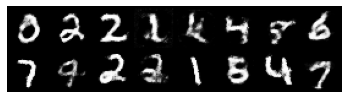

 56%|█████▋    | 113/200 [51:50<43:31, 30.02s/it]

Epoch 114: DL=-0.8801, GL=-0.4250


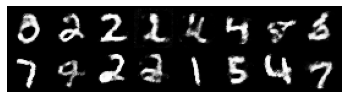

 57%|█████▋    | 114/200 [52:20<43:06, 30.08s/it]

Epoch 115: DL=-0.8791, GL=-0.4440


 57%|█████▊    | 115/200 [52:50<42:36, 30.08s/it]

Epoch 116: DL=-0.8904, GL=-0.4585


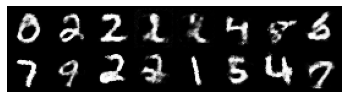

 58%|█████▊    | 116/200 [53:20<42:08, 30.10s/it]

Epoch 117: DL=-0.8836, GL=-0.4474


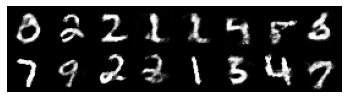

 58%|█████▊    | 117/200 [53:50<41:31, 30.02s/it]

Epoch 118: DL=-0.8927, GL=-0.4366


 59%|█████▉    | 118/200 [54:21<41:09, 30.12s/it]

Epoch 119: DL=-0.8805, GL=-0.4209


 60%|█████▉    | 119/200 [54:51<40:37, 30.10s/it]

Epoch 120: DL=-0.8577, GL=-0.4362


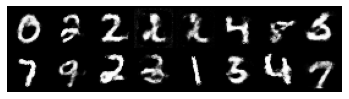

 60%|██████    | 120/200 [55:21<40:07, 30.09s/it]

Epoch 121: DL=-0.8587, GL=-0.5167


 60%|██████    | 121/200 [55:51<39:39, 30.12s/it]

Epoch 122: DL=-0.8554, GL=-0.4695


 61%|██████    | 122/200 [56:21<39:08, 30.10s/it]

Epoch 123: DL=-0.8680, GL=-0.4382


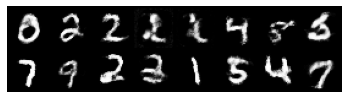

 62%|██████▏   | 123/200 [56:51<38:36, 30.08s/it]

Epoch 124: DL=-0.8648, GL=-0.4461


 62%|██████▏   | 124/200 [57:21<38:01, 30.02s/it]

Epoch 125: DL=-0.8478, GL=-0.4623


 62%|██████▎   | 125/200 [57:51<37:36, 30.08s/it]

Epoch 126: DL=-0.8584, GL=-0.4668


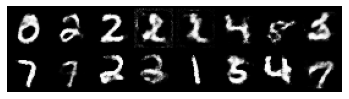

 63%|██████▎   | 126/200 [58:21<37:09, 30.13s/it]

Epoch 127: DL=-0.8630, GL=-0.4921


 64%|██████▎   | 127/200 [58:51<36:30, 30.01s/it]

Epoch 128: DL=-0.8452, GL=-0.4759


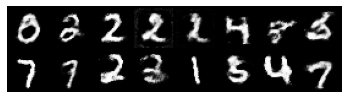

 64%|██████▍   | 128/200 [59:21<36:04, 30.07s/it]

Epoch 129: DL=-0.8421, GL=-0.5046


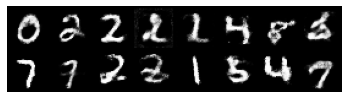

 64%|██████▍   | 129/200 [59:51<35:37, 30.11s/it]

Epoch 130: DL=-0.8519, GL=-0.4687


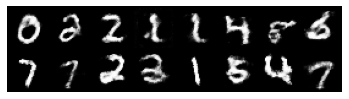

 65%|██████▌   | 130/200 [1:00:22<35:08, 30.12s/it]

Epoch 131: DL=-0.8374, GL=-0.4822


 66%|██████▌   | 131/200 [1:00:51<34:34, 30.07s/it]

Epoch 132: DL=-0.8432, GL=-0.4667


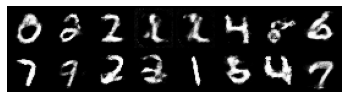

 66%|██████▌   | 132/200 [1:01:22<34:03, 30.06s/it]

Epoch 133: DL=-0.8303, GL=-0.4698


 66%|██████▋   | 133/200 [1:01:52<33:36, 30.10s/it]

Epoch 134: DL=-0.8391, GL=-0.4671


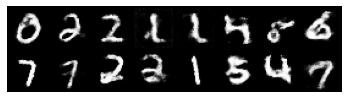

 67%|██████▋   | 134/200 [1:02:22<33:03, 30.06s/it]

Epoch 135: DL=-0.8254, GL=-0.4971


 68%|██████▊   | 135/200 [1:02:52<32:33, 30.06s/it]

Epoch 136: DL=-0.8398, GL=-0.4725


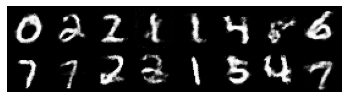

 68%|██████▊   | 136/200 [1:03:22<32:05, 30.08s/it]

Epoch 137: DL=-0.8260, GL=-0.5036


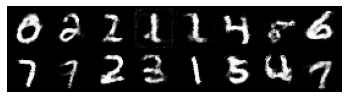

 68%|██████▊   | 137/200 [1:03:52<31:34, 30.07s/it]

Epoch 138: DL=-0.8316, GL=-0.5006


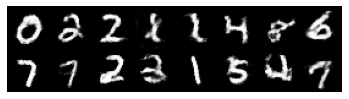

 69%|██████▉   | 138/200 [1:04:22<31:00, 30.01s/it]

Epoch 139: DL=-0.8201, GL=-0.4951


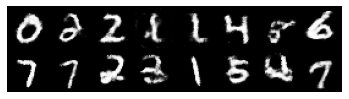

 70%|██████▉   | 139/200 [1:04:52<30:30, 30.01s/it]

Epoch 140: DL=-0.8241, GL=-0.4869


 70%|███████   | 140/200 [1:05:22<30:01, 30.02s/it]

Epoch 141: DL=-0.8311, GL=-0.5343


 70%|███████   | 141/200 [1:05:52<29:29, 29.99s/it]

Epoch 142: DL=-0.8204, GL=-0.4998


 71%|███████   | 142/200 [1:06:22<29:01, 30.03s/it]

Epoch 143: DL=-0.8231, GL=-0.4835


 72%|███████▏  | 143/200 [1:06:52<28:35, 30.10s/it]

Epoch 144: DL=-0.8236, GL=-0.4756


 72%|███████▏  | 144/200 [1:07:22<28:06, 30.11s/it]

Epoch 145: DL=-0.8144, GL=-0.4972


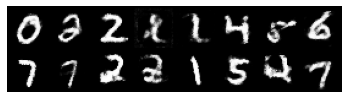

 72%|███████▎  | 145/200 [1:07:52<27:35, 30.10s/it]

Epoch 146: DL=-0.8003, GL=-0.5243


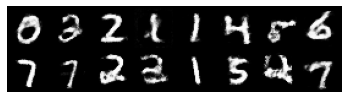

 73%|███████▎  | 146/200 [1:08:22<27:05, 30.10s/it]

Epoch 147: DL=-0.8177, GL=-0.4834


 74%|███████▎  | 147/200 [1:08:53<26:34, 30.09s/it]

Epoch 148: DL=-0.8091, GL=-0.4849


 74%|███████▍  | 148/200 [1:09:22<25:58, 29.98s/it]

Epoch 149: DL=-0.7953, GL=-0.5415


 74%|███████▍  | 149/200 [1:09:52<25:31, 30.03s/it]

Epoch 150: DL=-0.8002, GL=-0.4970


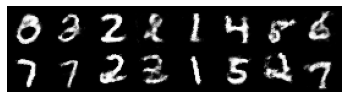

 75%|███████▌  | 150/200 [1:10:22<25:00, 30.02s/it]

Epoch 151: DL=-0.7912, GL=-0.4987


 76%|███████▌  | 151/200 [1:10:52<24:30, 30.01s/it]

Epoch 152: DL=-0.8052, GL=-0.4964


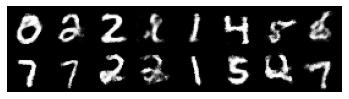

 76%|███████▌  | 152/200 [1:11:22<23:59, 29.99s/it]

Epoch 153: DL=-0.8006, GL=-0.4698


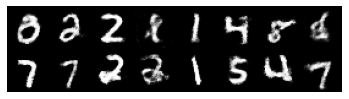

 76%|███████▋  | 153/200 [1:11:52<23:27, 29.95s/it]

Epoch 154: DL=-0.7902, GL=-0.4990


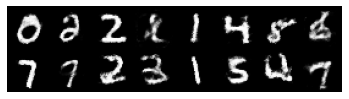

 77%|███████▋  | 154/200 [1:12:22<23:01, 30.03s/it]

Epoch 155: DL=-0.7970, GL=-0.5010


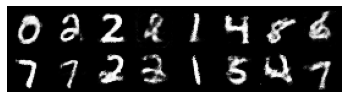

 78%|███████▊  | 155/200 [1:12:52<22:27, 29.94s/it]

Epoch 156: DL=-0.7861, GL=-0.5153


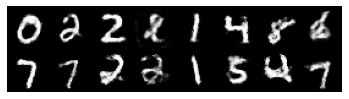

 78%|███████▊  | 156/200 [1:13:22<22:01, 30.03s/it]

Epoch 157: DL=-0.7773, GL=-0.4923


 78%|███████▊  | 157/200 [1:13:52<21:31, 30.05s/it]

Epoch 158: DL=-0.8049, GL=-0.5130


 79%|███████▉  | 158/200 [1:14:22<21:01, 30.04s/it]

Epoch 159: DL=-0.7954, GL=-0.4658


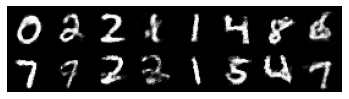

 80%|███████▉  | 159/200 [1:14:52<20:27, 29.95s/it]

Epoch 160: DL=-0.7765, GL=-0.4789


 80%|████████  | 160/200 [1:15:23<20:02, 30.07s/it]

Epoch 161: DL=-0.7845, GL=-0.5289


 80%|████████  | 161/200 [1:15:53<19:35, 30.15s/it]

Epoch 162: DL=-0.7728, GL=-0.5267


 81%|████████  | 162/200 [1:16:23<18:59, 29.99s/it]

Epoch 163: DL=-0.7715, GL=-0.5369


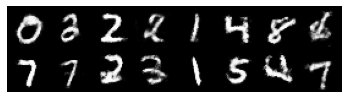

 82%|████████▏ | 163/200 [1:16:53<18:30, 30.01s/it]

Epoch 164: DL=-0.7764, GL=-0.4890


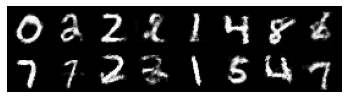

 82%|████████▏ | 164/200 [1:17:23<18:00, 30.01s/it]

Epoch 165: DL=-0.7654, GL=-0.5097


 82%|████████▎ | 165/200 [1:17:53<17:31, 30.03s/it]

Epoch 166: DL=-0.7632, GL=-0.5428


 83%|████████▎ | 166/200 [1:18:22<16:58, 29.96s/it]

Epoch 167: DL=-0.7638, GL=-0.4887


 84%|████████▎ | 167/200 [1:18:53<16:30, 30.01s/it]

Epoch 168: DL=-0.7619, GL=-0.5186


 84%|████████▍ | 168/200 [1:19:23<16:02, 30.07s/it]

Epoch 169: DL=-0.7683, GL=-0.5287


 84%|████████▍ | 169/200 [1:19:53<15:30, 30.01s/it]

Epoch 170: DL=-0.7576, GL=-0.5216


 85%|████████▌ | 170/200 [1:20:23<15:00, 30.00s/it]

Epoch 171: DL=-0.7424, GL=-0.5511


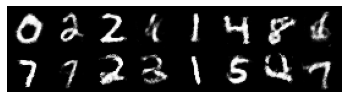

 86%|████████▌ | 171/200 [1:20:53<14:29, 29.97s/it]

Epoch 172: DL=-0.7478, GL=-0.5369


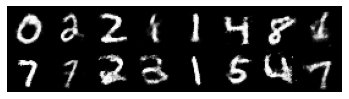

 86%|████████▌ | 172/200 [1:21:23<14:00, 30.02s/it]

Epoch 173: DL=-0.7513, GL=-0.5370


 86%|████████▋ | 173/200 [1:21:53<13:30, 30.01s/it]

Epoch 174: DL=-0.7465, GL=-0.5204


 87%|████████▋ | 174/200 [1:22:23<13:01, 30.05s/it]

Epoch 175: DL=-0.7464, GL=-0.5429


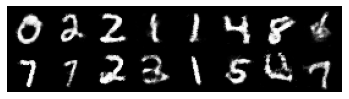

 88%|████████▊ | 175/200 [1:22:53<12:31, 30.06s/it]

Epoch 176: DL=-0.7549, GL=-0.5386


 88%|████████▊ | 176/200 [1:23:23<12:00, 30.03s/it]

Epoch 177: DL=-0.7461, GL=-0.5218


 88%|████████▊ | 177/200 [1:23:53<11:30, 30.03s/it]

Epoch 178: DL=-0.7311, GL=-0.5344


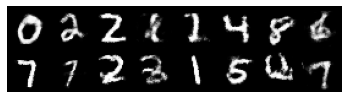

 89%|████████▉ | 178/200 [1:24:23<11:01, 30.08s/it]

Epoch 179: DL=-0.7436, GL=-0.5537


 90%|████████▉ | 179/200 [1:24:53<10:30, 30.03s/it]

Epoch 180: DL=-0.7294, GL=-0.5734


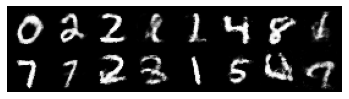

 90%|█████████ | 180/200 [1:25:23<10:01, 30.07s/it]

Epoch 181: DL=-0.7284, GL=-0.5566


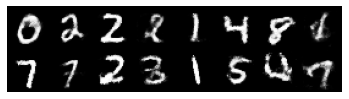

 90%|█████████ | 181/200 [1:25:53<09:31, 30.06s/it]

Epoch 182: DL=-0.7287, GL=-0.5465


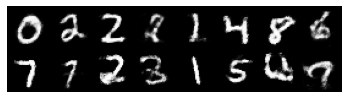

 91%|█████████ | 182/200 [1:26:23<09:02, 30.13s/it]

Epoch 183: DL=-0.7347, GL=-0.5849


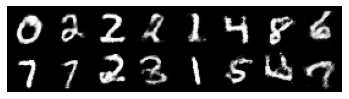

 92%|█████████▏| 183/200 [1:26:53<08:30, 30.02s/it]

Epoch 184: DL=-0.7338, GL=-0.5499


 92%|█████████▏| 184/200 [1:27:23<08:00, 30.06s/it]

Epoch 185: DL=-0.7297, GL=-0.5839


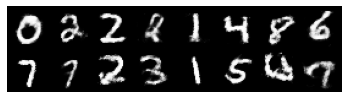

 92%|█████████▎| 185/200 [1:27:54<07:31, 30.10s/it]

Epoch 186: DL=-0.7228, GL=-0.6157


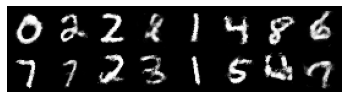

 93%|█████████▎| 186/200 [1:28:24<07:00, 30.05s/it]

Epoch 187: DL=-0.7315, GL=-0.5439


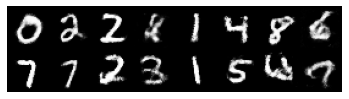

 94%|█████████▎| 187/200 [1:28:54<06:30, 30.05s/it]

Epoch 188: DL=-0.7262, GL=-0.5854


 94%|█████████▍| 188/200 [1:29:24<06:00, 30.07s/it]

Epoch 189: DL=-0.7201, GL=-0.5476


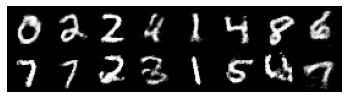

 94%|█████████▍| 189/200 [1:29:54<05:31, 30.12s/it]

Epoch 190: DL=-0.7320, GL=-0.5553


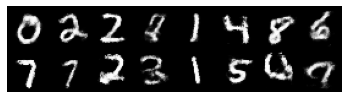

 95%|█████████▌| 190/200 [1:30:24<05:00, 30.05s/it]

Epoch 191: DL=-0.7240, GL=-0.5991


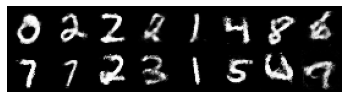

 96%|█████████▌| 191/200 [1:30:54<04:30, 30.07s/it]

Epoch 192: DL=-0.6988, GL=-0.5833


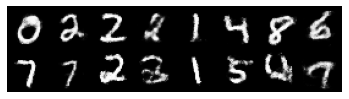

 96%|█████████▌| 192/200 [1:31:24<04:00, 30.06s/it]

Epoch 193: DL=-0.7152, GL=-0.5699


 96%|█████████▋| 193/200 [1:31:54<03:29, 29.96s/it]

Epoch 194: DL=-0.7023, GL=-0.5772


 97%|█████████▋| 194/200 [1:32:24<02:59, 29.99s/it]

Epoch 195: DL=-0.7179, GL=-0.5653


 98%|█████████▊| 195/200 [1:32:54<02:30, 30.03s/it]

Epoch 196: DL=-0.7137, GL=-0.5412


 98%|█████████▊| 196/200 [1:33:24<02:00, 30.08s/it]

Epoch 197: DL=-0.6972, GL=-0.5764


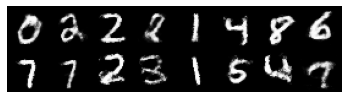

 98%|█████████▊| 197/200 [1:33:54<01:30, 30.01s/it]

Epoch 198: DL=-0.7073, GL=-0.5686


 99%|█████████▉| 198/200 [1:34:24<01:00, 30.06s/it]

Epoch 199: DL=-0.7081, GL=-0.5295


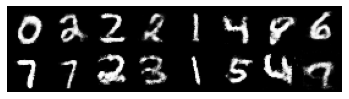

100%|█████████▉| 199/200 [1:34:54<00:30, 30.10s/it]

Epoch 200: DL=-0.6916, GL=-0.5396


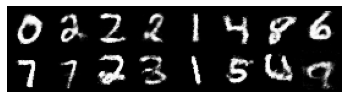

100%|██████████| 200/200 [1:35:24<00:00, 28.62s/it]


In [8]:
# ----------
#  Training
# ----------
fixed_noise = Tensor(np.random.normal(0, 1, (32, opt.latent_dim)))
batches_done = 0

# Loss history
hist_d_loss = []
hist_g_loss = []

for epoch in tqdm(range(opt.n_epochs)):
    # Losses 
    sum_d_loss = 0
    sum_g_loss = 0
    
    discriminator.train()
    generator.train()
    
    for i, (imgs, _) in enumerate(dataloader):
        
        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        sum_d_loss += float(d_loss)
        
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)
            
            sum_g_loss += float(g_loss)

            g_loss.backward()
            optimizer_G.step()            
            
            if batches_done % opt.sample_interval == 0:
                save_image(fake_imgs.data[:25], os.path.join(opt.data_dir, "images_wgan_gp_original/%d.png" % batches_done), nrow=5, normalize=True)

            batches_done += opt.n_critic
      
    epoch_d_loss = sum_d_loss/len(dataloader)
    epoch_g_loss = sum_g_loss/len(dataloader)
    hist_d_loss.append(epoch_d_loss)
    hist_g_loss.append(epoch_g_loss)
    print(f"Epoch {epoch+1}: DL={epoch_d_loss:.4f}, GL={epoch_g_loss:.4f}")
    
    generator.eval()
        
    with torch.no_grad():
        g_output = generator(fixed_noise)[:16,:,:]
        plt.imshow(transforms.ToPILImage()(make_grid(g_output, scale_each=True, normalize=True).cpu()))
        plt.axis('off')
        plt.show()

In [9]:
# Plot loss
plt.title("Loss")
plt.plot(hist_d_loss, label="DL")
plt.plot(hist_g_loss, label="GL")
plt.legend()
plt.show()